# Wine Quality Prediction using Machine Learning

## Project Overview

This notebook explores the prediction of wine quality using machine learning techniques. We'll analyze the UC Irvine Wine Quality dataset, which contains physicochemical properties of wines and their quality ratings.

### Objectives
- Explore and understand the wine quality dataset
- Implement machine learning models from scratch
- Compare different modeling approaches (linear regression vs. logistic regression)
- Evaluate model performance and interpret results

### Dataset
The dataset contains 11 physicochemical features and quality ratings for red wine samples. This analysis will help us understand which chemical properties most influence wine quality.

In [105]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from ucimlrepo import fetch_ucirepo
from time import time

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib for better plots
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'

# Fetch the wine quality dataset from UCI ML Repository
print("Loading Wine Quality dataset...")
wine_quality = fetch_ucirepo(id=186)
print("Dataset loaded successfully!") 

Loading Wine Quality dataset...
Dataset loaded successfully!


## Data Exploration

Let's start by examining the structure and characteristics of our dataset. We'll look at the features, their distributions, and understand what each variable represents in the context of wine quality assessment.

In [2]:
# Extract features and target variable
X = wine_quality.data.features 
y = wine_quality.data.targets

# Display basic dataset information
print("Dataset Information:")
print(f"Number of samples: {len(X)}")
print(f"Number of features: {len(X.columns)}")
print(f"Target variable: {y.columns[0]}")
print()

# Display feature names
print("Features in the dataset:")
for i, feature in enumerate(X.columns):
    print(f"  {i+1:2d}. {feature}")

print("\n" + "="*50)
print("Sample Data Preview:")
print("="*50)

print("\nFeature Data (first 5 samples):")
display(X.head())

print("\nTarget Data (first 5 samples):")
display(y.head())

print(f"\nTarget distribution (quality ratings):")
display(y['quality'].value_counts().sort_index())

Dataset Information:
Number of samples: 6497
Number of features: 11
Target variable: quality

Features in the dataset:
   1. fixed_acidity
   2. volatile_acidity
   3. citric_acid
   4. residual_sugar
   5. chlorides
   6. free_sulfur_dioxide
   7. total_sulfur_dioxide
   8. density
   9. pH
  10. sulphates
  11. alcohol

Sample Data Preview:

Feature Data (first 5 samples):


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4



Target Data (first 5 samples):


,quality
0,5
1,5
2,5
3,6
4,5



Target distribution (quality ratings):


quality
3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: count, dtype: int64

### Feature Descriptions

Understanding the physicochemical properties that influence wine quality is crucial for our analysis. Here's a detailed explanation of each feature:

#### Chemical Properties
* **Fixed Acidity**: Tartaric acid content (g/dm³) - Primary acid in grapes that balances sweetness
* **Volatile Acidity**: Acetic acid content (g/dm³) - Can produce vinegar-like taste at high levels
* **Citric Acid**: Citric acid content (g/dm³) - Added to enhance freshness and flavor
* **pH**: Acidity level (3-4 scale) - Lower values indicate higher acidity

#### Preservation & Additives
* **Free Sulfur Dioxide**: Unbound SO₂ (mg/dm³) - Acts as antioxidant and antimicrobial
* **Total Sulfur Dioxide**: Total SO₂ (mg/dm³) - Includes both free and bound forms
* **Sulphates**: Sulfate content (g/dm³) - Natural preservative preventing spoilage
* **Chlorides**: Chloride content (g/dm³) - Influenced by geographical factors

#### Physical Properties
* **Density**: Wine density (g/cm³) - Affected by sugar and alcohol content
* **Residual Sugar**: Remaining grape sugar (g/dm³) - Determines sweetness level
* **Alcohol**: Alcohol percentage by volume - Key factor in wine character

Now let's examine the distribution of these features to better understand our dataset.

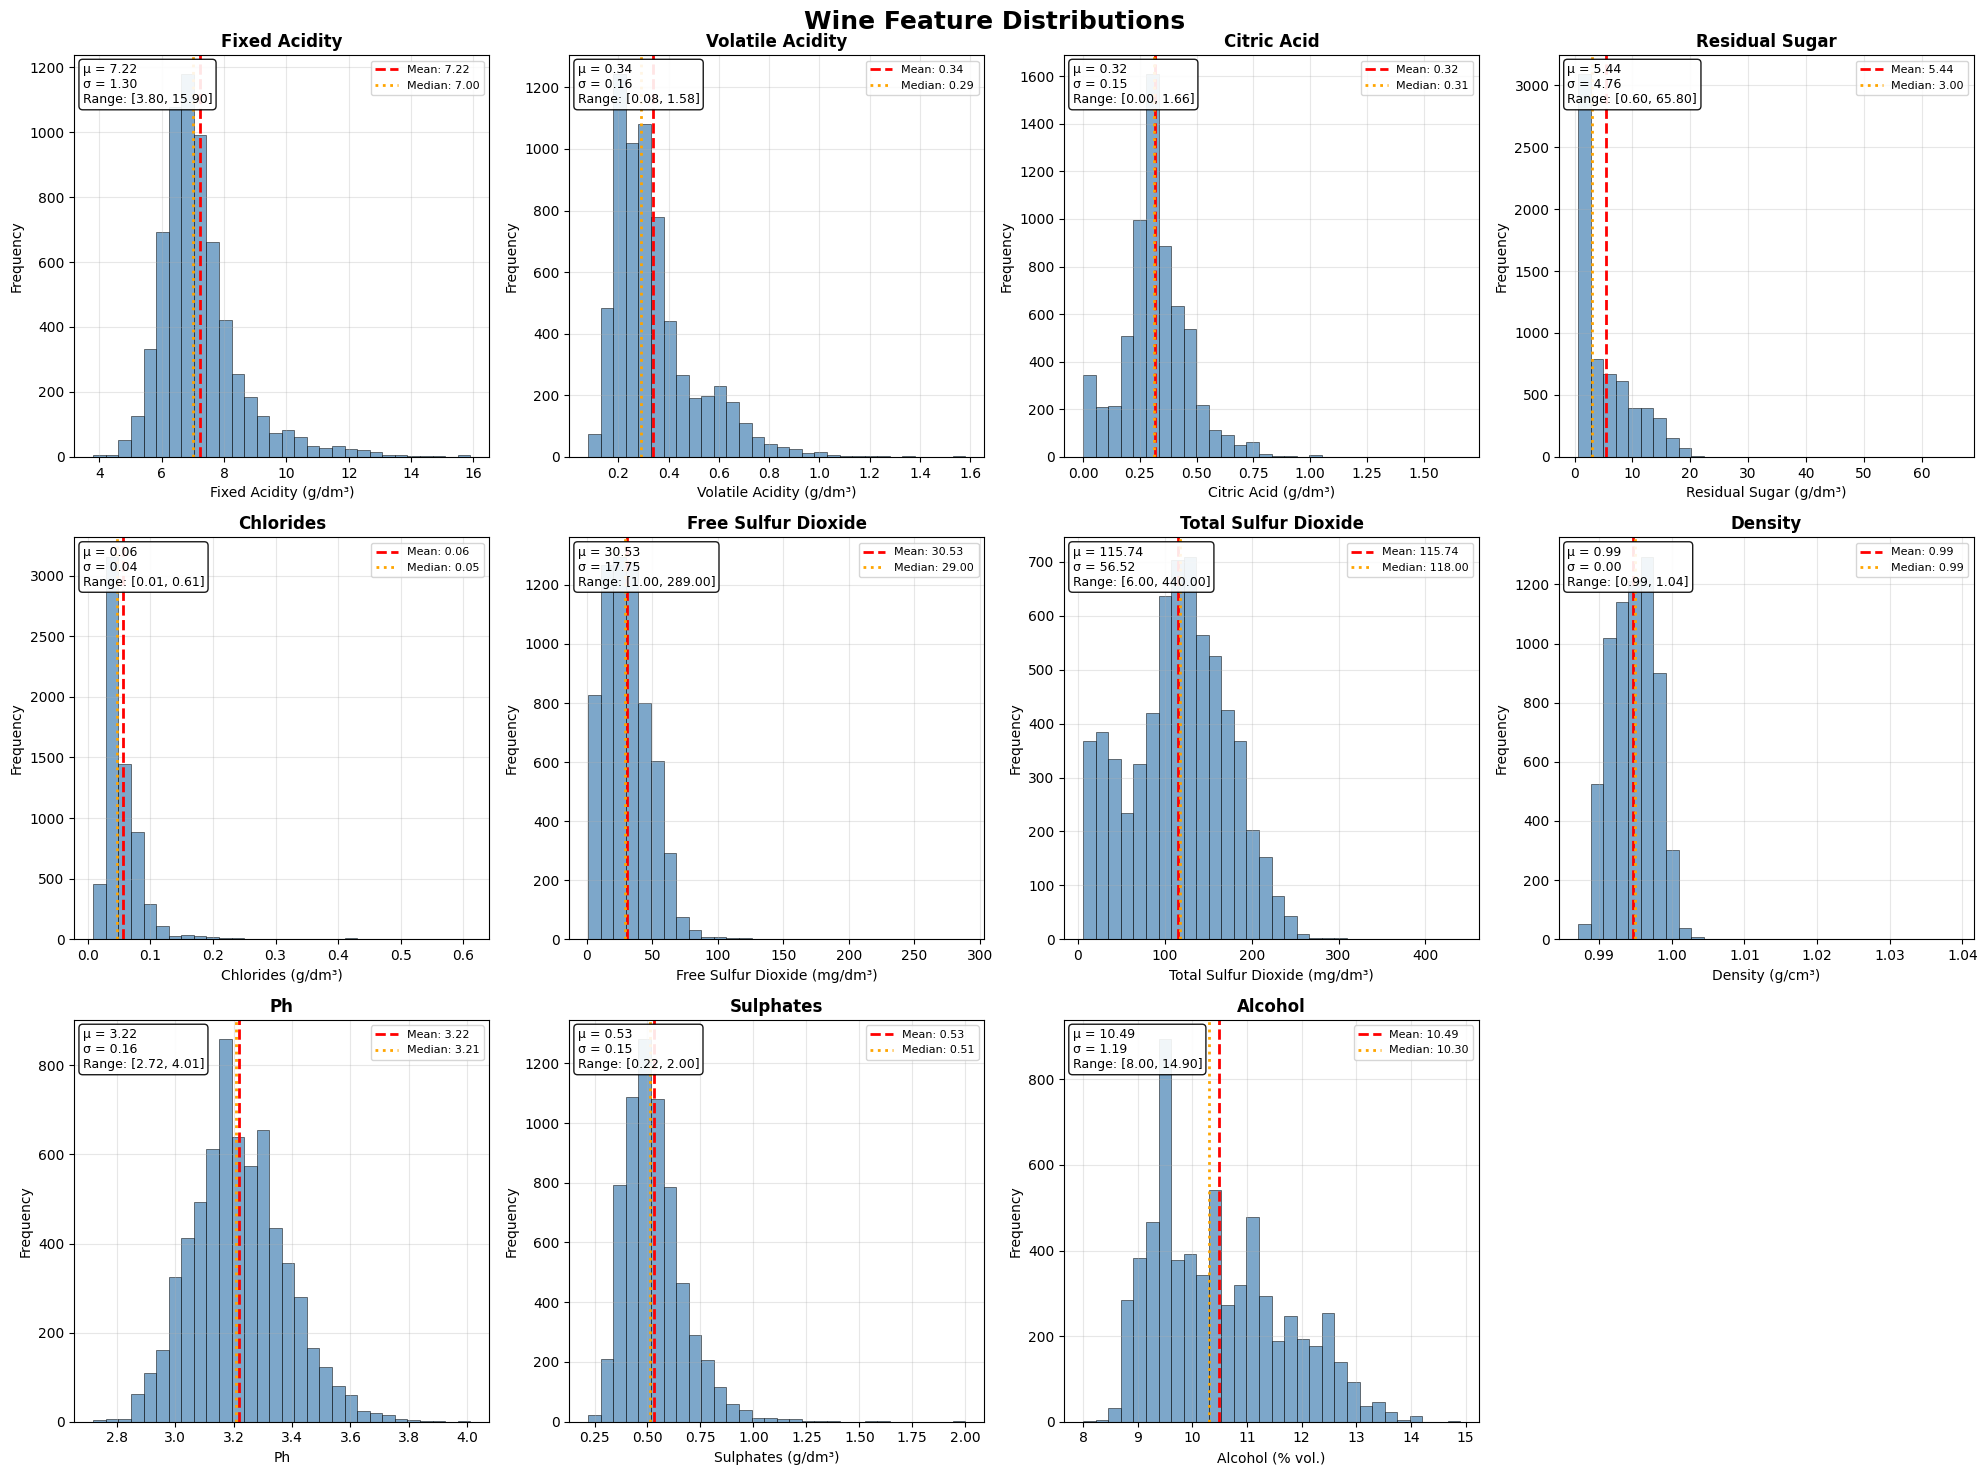


Feature Summary Statistics:


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,6497.000,6497.000,6497.000,6497.000,6497.000,6497.000,6497.000,6497.000,6497.000,6497.000,6497.000
mean,7.215,0.340,0.319,5.443,0.056,30.525,115.745,0.995,3.219,0.531,10.492
std,1.296,0.165,0.145,4.758,0.035,17.749,56.522,0.003,0.161,0.149,1.193
min,3.800,0.080,0.000,0.600,0.009,1.000,6.000,0.987,2.720,0.220,8.000
25%,6.400,0.230,0.250,1.800,0.038,17.000,77.000,0.992,3.110,0.430,9.500
50%,7.000,0.290,0.310,3.000,0.047,29.000,118.000,0.995,3.210,0.510,10.300
75%,7.700,0.400,0.390,8.100,0.065,41.000,156.000,0.997,3.320,0.600,11.300
max,15.900,1.580,1.660,65.800,0.611,289.000,440.000,1.039,4.010,2.000,14.900


In [3]:
# Create comprehensive feature distribution plots
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle('Wine Feature Distributions', fontsize=18, fontweight='bold', y=0.98)

# Define units for each feature
feature_units = {
    'fixed_acidity': r'(g/dm³)',
    'volatile_acidity': r'(g/dm³)',
    'citric_acid': r'(g/dm³)',
    'residual_sugar': r'(g/dm³)',
    'chlorides': r'(g/dm³)',
    'free_sulfur_dioxide': r'(mg/dm³)',
    'total_sulfur_dioxide': r'(mg/dm³)',
    'density': r'(g/cm³)',
    'pH': '',
    'sulphates': r'(g/dm³)',
    'alcohol': r'(% vol.)'
}

# Flatten axes for easier indexing
axes = axes.flatten()

# Create histograms for each feature
for i, feature in enumerate(X.columns):
    ax = axes[i]
    
    # Create histogram with improved styling
    n, bins, patches = ax.hist(X[feature], bins=30, alpha=0.7, 
                              color='steelblue', edgecolor='black', linewidth=0.5)
    
    # Calculate statistics
    mean_val = X[feature].mean()
    median_val = X[feature].median()
    std_val = X[feature].std()
    
    # Add vertical lines for mean and median
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {mean_val:.2f}')
    ax.axvline(median_val, color='orange', linestyle=':', linewidth=2, 
               label=f'Median: {median_val:.2f}')
    
    # Add statistical information as text
    stats_text = f'μ = {mean_val:.2f}\nσ = {std_val:.2f}\nRange: [{X[feature].min():.2f}, {X[feature].max():.2f}]'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    # Format axis labels
    unit = feature_units.get(feature, '')
    feature_name = feature.replace("_", " ").title()
    xlabel = f'{feature_name} {unit}' if unit else feature_name

    # Customize the plot
    ax.set_title(feature_name, fontweight='bold', fontsize=12)
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

# Hide the unused subplot (12th position)
axes[11].set_visible(False)

# Adjust layout and display
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

# Print summary statistics
print("\nFeature Summary Statistics:")
print("=" * 60)
display(X.describe().round(3))

## Data Preprocessing

Before building our models, we need to prepare the data. This involves checking for missing values, standardizing features, and splitting the data into training and testing sets.

### Missing Values Analysis

First, let's check if there are any missing values in our dataset that need to be addressed.

In [4]:
# Check for missing values in features
missing_features = X.isnull().sum()
print("Missing values in features:")
print(missing_features)
print(f"\nTotal missing values: {missing_features.sum()}")

# Check for missing values in target
missing_target = y.isnull().sum()
print(f"\nMissing values in target: {missing_target.values[0]}")

# Summary
if missing_features.sum() == 0 and missing_target.sum() == 0:
    print("\n✓ Excellent! No missing values found in the dataset.")
else:
    print(f"\n⚠ Warning: Found {missing_features.sum() + missing_target.sum()} missing values that need to be addressed.")

Missing values in features:
fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
dtype: int64

Total missing values: 0

Missing values in target: 0

✓ Excellent! No missing values found in the dataset.


### Data Standardization and Train-Test Split

Since we have no missing values, we can proceed with data standardization. Standardization is crucial for machine learning algorithms as it ensures all features contribute equally to the model regardless of their scale.

We'll use z-score normalization: `(x - μ) / σ` where μ is the mean and σ is the standard deviation.

In [5]:
# Define train-test split ratio
TRAIN_SIZE = 0.8
TEST_SIZE = 1 - TRAIN_SIZE

print(f"Data split: {TRAIN_SIZE*100:.0f}% training, {TEST_SIZE*100:.0f}% testing")

# Calculate standardization parameters from the full dataset
X_means = X.mean()
X_stds = X.std()
y_means = y.mean()
y_stds = y.std()

# Apply standardization
X_norm = (X - X_means) / X_stds
y_norm = (y - y_means) / y_stds

print(f"\nStandardization completed:")
print(f"Features - Mean: {X_norm.mean().mean():.2e}, Std: {X_norm.std().mean():.2f}")
print(f"Target - Mean: {y_norm.mean().values[0]:.2e}, Std: {y_norm.std().values[0]:.2f}")

# Split data into training and testing sets
split_idx = int(TRAIN_SIZE * len(X_norm))

X_train = X_norm.iloc[:split_idx]
X_test = X_norm.iloc[split_idx:]
y_train = y_norm.iloc[:split_idx]
y_test = y_norm.iloc[split_idx:]

# Verify data integrity
data_integrity = (len(X_norm) == len(X_train) + len(X_test)) and (len(y_norm) == len(y_train) + len(y_test))
print(f"\nData integrity check: {'✓ PASSED' if data_integrity else '✗ FAILED'}")

# Display dataset information
print("\nDataset Shapes:")
print(f"{'Set':<10} {'Features':<15} {'Target':<15}")
print("-" * 40)
print(f"{'Training':<10} {str(X_train.shape):<15} {str(y_train.shape):<15}")
print(f"{'Testing':<10} {str(X_test.shape):<15} {str(y_test.shape):<15}")
print(f"{'Total':<10} {str(X_norm.shape):<15} {str(y_norm.shape):<15}")

# Display target distribution in training set
print(f"\nTarget distribution in training set:")
print(f"Quality range: [{y_train.min().values[0]:.2f}, {y_train.max().values[0]:.2f}]")

Data split: 80% training, 20% testing

Standardization completed:
Features - Mean: -9.23e-17, Std: 1.00
Target - Mean: -2.89e-16, Std: 1.00

Data integrity check: ✓ PASSED

Dataset Shapes:
Set        Features        Target         
----------------------------------------
Training   (5197, 11)      (5197, 1)      
Testing    (1300, 11)      (1300, 1)      
Total      (6497, 11)      (6497, 1)      

Target distribution in training set:
Quality range: [-3.23, 3.64]


In [6]:
# Store original data for later use
X_original = X.copy()
y_original = y.copy()

print("✓ Data preprocessing completed successfully!")
print("✓ Ready to proceed with machine learning models.")


✓ Data preprocessing completed successfully!
✓ Ready to proceed with machine learning models.


## Machine Learning Models

Now we'll implement and compare different machine learning approaches to predict wine quality. We'll start with simpler models and progress to more complex ones, implementing each from scratch to demonstrate the underlying principles.

### 1. Simple Linear Regression (Single Feature)

As a baseline, we'll start with the simplest possible model: linear regression using only one feature. We'll use pH as our single predictor since it showed a relatively normal distribution in our exploratory analysis.

#### Model Definition
Our linear model predicts wine quality as:

$$\hat{y} = \theta_0 + \theta_1 x$$

Where:
- $\hat{y}$ = predicted wine quality (standardized)
- $x$ = pH value (standardized)
- $\theta_0$ = intercept parameter
- $\theta_1$ = slope parameter

#### Cost Function
We use Mean Squared Error (MSE) as our cost function:

$$J(\boldsymbol{\theta}) = \frac{1}{2m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)})^2$$

#### Parameter Optimization
We'll use gradient descent to find optimal parameters. The gradients are:

$$\frac{\partial J}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)})$$

$$\frac{\partial J}{\partial \theta_1} = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)}) x^{(i)}$$

Parameter updates:
$$\theta_j := \theta_j - \alpha \frac{\partial J}{\partial \theta_j}$$

Where $\alpha$ is the learning rate.

In [7]:
class SimpleLinearRegression:
    """
    Simple Linear Regression implementation using gradient descent
    """
    
    def __init__(self, learning_rate=0.01, max_iterations=1000, tolerance=1e-6):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.theta_0 = 0
        self.theta_1 = 0
        self.cost_history = []
        
    def cost_function(self, X, y):
        """Calculate Mean Squared Error cost"""
        m = len(X)
        predictions = self.theta_0 + self.theta_1 * X
        return (1/(2*m)) * np.sum((predictions - y)**2)
    
    def fit(self, X, y):
        """Train the model using gradient descent"""
        m = len(X)
        
        # Record initial cost
        initial_cost = self.cost_function(X, y)
        self.cost_history.append(initial_cost)
        
        print(f"Starting training with initial cost: {initial_cost:.6f}")
        
        for iteration in range(self.max_iterations):
            # Calculate predictions
            predictions = self.theta_0 + self.theta_1 * X
            errors = predictions - y
            
            # Calculate gradients
            theta_0_grad = (1/m) * np.sum(errors)
            theta_1_grad = (1/m) * np.sum(errors * X)
            
            # Update parameters
            self.theta_0 -= self.learning_rate * theta_0_grad
            self.theta_1 -= self.learning_rate * theta_1_grad
            
            # Calculate new cost
            current_cost = self.cost_function(X, y)
            self.cost_history.append(current_cost)
            
            # Print progress
            if iteration % 100 == 0:
                print(f"Iteration {iteration:4d}: Cost = {current_cost:.6f}")
                
            # Check for convergence
            if len(self.cost_history) > 1:
                cost_change = abs(self.cost_history[-2] - self.cost_history[-1])
                if cost_change < self.tolerance:
                    print(f"Converged at iteration {iteration} (cost change: {cost_change:.2e})")
                    break
                    
        final_cost = self.cost_history[-1]
        print(f"Training completed. Final cost: {final_cost:.6f}")
        return self
    
    def predict(self, X):
        """Make predictions using the trained model"""
        return self.theta_0 + self.theta_1 * X

# Prepare data for simple linear regression
X_linear = X_train['pH'].to_numpy()
y_linear = y_train.to_numpy().flatten()

print("Simple Linear Regression Training")
print("=" * 40)
print(f"Feature: pH")
print(f"Training samples: {len(X_linear)}")
print(f"Learning rate: 0.01")
print()

# Train the model
model_linear = SimpleLinearRegression(learning_rate=0.1, max_iterations=1000)
model_linear.fit(X_linear, y_linear)

print(f"\nLearned parameters:")
print(f"θ₀ (intercept): {model_linear.theta_0:.6f}")
print(f"θ₁ (slope): {model_linear.theta_1:.6f}")

Simple Linear Regression Training
Feature: pH
Training samples: 5197
Learning rate: 0.01

Starting training with initial cost: 0.519063
Iteration    0: Cost = 0.518987
Converged at iteration 23 (cost change: 8.23e-07)
Training completed. Final cost: 0.518642

Learned parameters:
θ₀ (intercept): -0.017197
θ₁ (slope): 0.021136


#### Training Progress Visualization

Let's visualize how the cost function decreased during training to understand the convergence behavior.

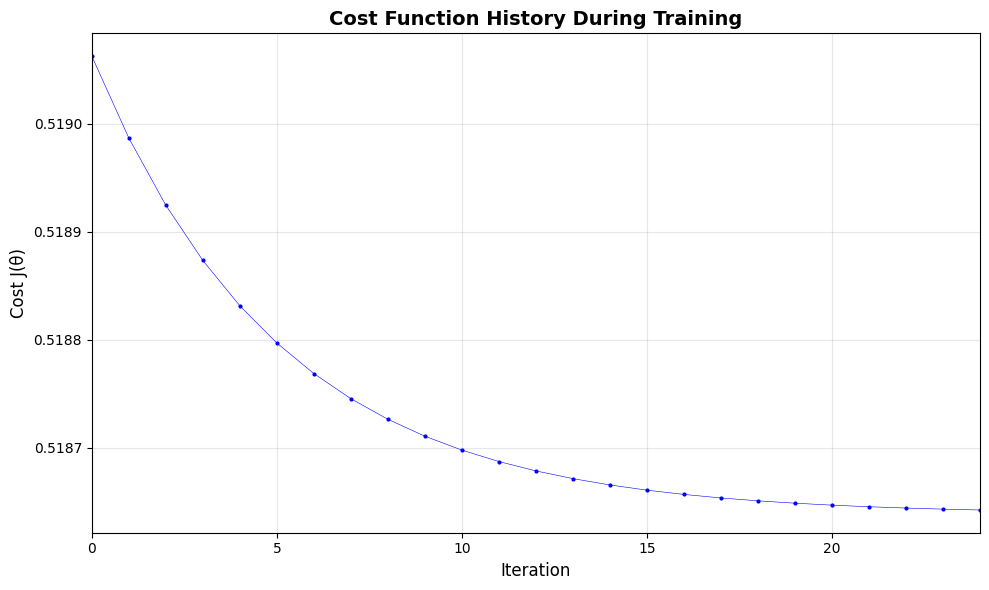

In [8]:
# Plot the cost history
cost_array = model_linear.cost_history

plt.figure(figsize=(10, 6))
plt.plot(range(len(cost_array)), cost_array, 'b-', linewidth=0.4, marker='o', markersize=2)
plt.title('Cost Function History During Training', fontsize=14, fontweight='bold')
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Cost J(θ)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(0, len(cost_array)-1)

plt.tight_layout()
plt.show()

# Print some statistics about the cost reduction
initial_cost = cost_array[0]
final_cost = cost_array[-1]
cost_reduction = initial_cost - final_cost
percent_reduction = (cost_reduction / initial_cost) * 100


#### Model Evaluation and Visualization

Now let's evaluate our simple linear regression model using standard metrics and visualize the results. We'll calculate the R² score and create a comprehensive visualization of the model's performance.

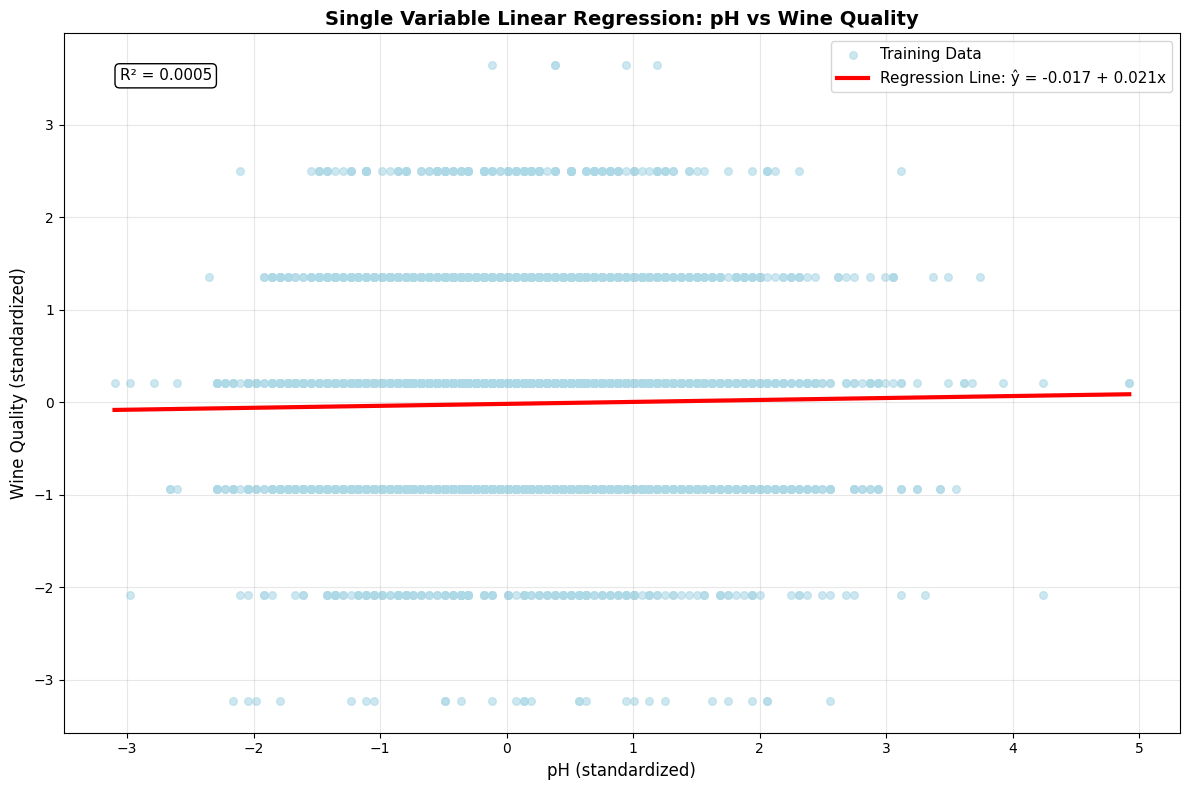

R² Score: 0.000525


In [9]:
# Plot the linear regression line with the data
plt.figure(figsize=(12, 8))

# Plot the training data points
plt.scatter(X_linear, y_linear, alpha=0.6, color='lightblue', s=30, label='Training Data')

# Create a range of x values for the regression line
x_range = np.linspace(X_linear.min(), X_linear.max(), 100)
y_pred = model_linear.theta_0 + model_linear.theta_1 * x_range

# Plot the regression line
plt.plot(x_range, y_pred, 'r-', linewidth=3, label=f'Regression Line: ŷ = {model_linear.theta_0:.3f} + {model_linear.theta_1:.3f}x')

# Customize the plot
plt.title('Single Variable Linear Regression: pH vs Wine Quality', fontsize=14, fontweight='bold')
plt.xlabel('pH (standardized)', fontsize=12)
plt.ylabel('Wine Quality (standardized)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

# Add R^2 score
r_squared = 1 - (np.sum((y_linear - (model_linear.theta_0 + model_linear.theta_1 * X_linear))**2) / 
                 np.sum((y_linear - np.mean(y_linear))**2))

plt.text(0.05, 0.95, f'R² = {r_squared:.4f}', 
         transform=plt.gca().transAxes, fontsize=11, 
         bbox=dict(boxstyle='round', facecolor='white'),
         verticalalignment='top')

plt.tight_layout()
plt.show()

print(f"R² Score: {r_squared:.6f}")


Unsurprisingly, the linear regression model performed poorly.


### 2. Logistic Regression (Multiple Features)

Now let's implement a more sophisticated model using logistic regression with all available features. We'll transform this into a binary classification problem to predict whether a wine is "high quality" or not.

#### Problem Transformation
Since wine quality is rated on a scale (1-10), we'll convert this to a binary classification:
- **High Quality**: Wine quality ≥ 7 (label = 1)
- **Low Quality**: Wine quality < 7 (label = 0)

#### Model Definition
Our logistic regression model uses the sigmoid function:

$$\hat{y} = \sigma(X\boldsymbol{\theta}) = \frac{1}{1 + e^{-X\boldsymbol{\theta}}}$$

Where:
- $X$ is our feature matrix (all 11 features)
- $\boldsymbol{\theta}$ is our parameter vector
- $\sigma$ is the sigmoid activation function

#### Cost Function
We use Binary Cross-Entropy Loss:

$$J(\boldsymbol{\theta}) = -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log(\hat{y}^{(i)}) + (1 - y^{(i)}) \log(1 - \hat{y}^{(i)}) \right]$$

#### Gradient
The gradient for parameter updates is:

$$\nabla J(\boldsymbol{\theta}) = \frac{1}{m} X^T (\hat{y} - y)$$

This is identical to linear regression, but with the sigmoid function applied to predictions.

In [10]:
class LogisticRegression:
    """
    Logistic Regression implementation using gradient descent
    """
    
    def __init__(self, learning_rate=0.01, max_iterations=1000, tolerance=1e-6):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.theta = None
        self.cost_history = []
        
    def sigmoid(self, z):
        """Sigmoid activation function"""
        return 1 / (1 + np.exp(-z))
    
    def cost_function(self, X, y):
        """Calculate Binary Cross-Entropy cost"""
        m = len(X)
        z = X @ self.theta
        h = self.sigmoid(z)
        
        cost = -(1/m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
        return cost
    
    def fit(self, X, y):
        """Train the model using gradient descent"""
        m, n = X.shape
        
        # Initialize parameters
        self.theta = np.random.normal(0, 0.01, (n, 1))
        
        # Record initial cost
        initial_cost = self.cost_function(X, y)
        self.cost_history.append(initial_cost)
        
        print(f"Starting logistic regression training...")
        print(f"Initial cost: {initial_cost:.6f}")
        print(f"Features: {n}, Samples: {m}")
        print()
        
        for iteration in range(self.max_iterations):
            # Forward pass
            z = X @ self.theta
            h = self.sigmoid(z)
            
            # Calculate gradient
            gradient = (1/m) * X.T @ (h - y)
            
            # Update parameters
            self.theta -= self.learning_rate * gradient
            
            # Calculate new cost
            current_cost = self.cost_function(X, y)
            self.cost_history.append(current_cost)
            
            # Print progress
            if iteration % 100 == 0:
                print(f"Iteration {iteration:4d}: Cost = {current_cost:.6f}")
                
            # Check for convergence
            if len(self.cost_history) > 1:
                cost_change = abs(self.cost_history[-2] - self.cost_history[-1])
                if cost_change < self.tolerance:
                    print(f"Converged at iteration {iteration} (cost change: {cost_change:.2e})")
                    break
                    
        final_cost = self.cost_history[-1]
        print(f"Training completed. Final cost: {final_cost:.6f}")
        return self
    
    def predict_proba(self, X):
        """Predict class probabilities"""
        z = X @ self.theta
        return self.sigmoid(z)
    
    def predict(self, X, threshold=0.5):
        """Make binary predictions"""
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)

# Data preparation for logistic regression
print("Preparing data for logistic regression...")
print("=" * 45)

# Transform target to binary classification (quality >= 7 = 1, else 0)
quality_threshold = 7
y_binary = (y_original['quality'] >= quality_threshold).astype(int).values.reshape(-1, 1)

# Split binary target
y_train_binary = y_binary[:len(X_train)]
y_test_binary = y_binary[len(X_train):]

# Use standardized features
X_train_logistic = X_train.values
X_test_logistic = X_test.values

# Display class distribution
train_positive = np.sum(y_train_binary)
train_total = len(y_train_binary)
test_positive = np.sum(y_test_binary)
test_total = len(y_test_binary)

print(f"Quality threshold: {quality_threshold}")
print(f"Training set: {train_positive}/{train_total} ({train_positive/train_total*100:.1f}%) high quality")
print(f"Test set: {test_positive}/{test_total} ({test_positive/test_total*100:.1f}%) high quality")
print()

# Train logistic regression model
model_logistic = LogisticRegression(learning_rate=0.2, max_iterations=250)
model_logistic.fit(X_train_logistic, y_train_binary)
print("=" * 45)


Preparing data for logistic regression...
Quality threshold: 7
Training set: 1030/5197 (19.8%) high quality
Test set: 247/1300 (19.0%) high quality

Starting logistic regression training...
Initial cost: 0.695249
Features: 11, Samples: 5197

Iteration    0: Cost = 0.679790
Iteration  100: Cost = 0.588730
Iteration  200: Cost = 0.587354
Training completed. Final cost: 0.587092


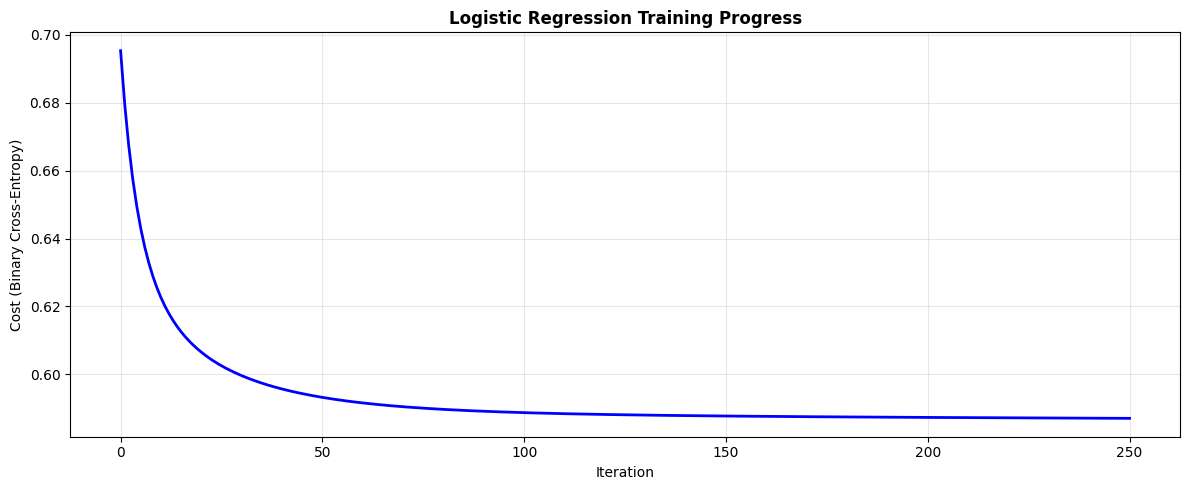

Training completed in 250 iterations
Final training cost: 0.587092


In [11]:
# Visualize training progress
plt.figure(figsize=(12, 5))

# Plot cost history
plt.plot(range(len(model_logistic.cost_history)), model_logistic.cost_history, 'b-', linewidth=2)
plt.title('Logistic Regression Training Progress', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('Cost (Binary Cross-Entropy)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Training completed in {len(model_logistic.cost_history)-1} iterations")
print(f"Final training cost: {model_logistic.cost_history[-1]:.6f}")

Since this model is more robust, let's evaluate it in a bit more detail. I want to look at the following metrics:
* **Accuracy** : How often the model correctly predicts the quality of the wine
* **Precision** : The percentage of true positives out of all predicted positives
* **Recall** : The percentage of true positives out of all *actual* positives
* **F1-Score** : The harmonic mean of precision and recall - a balance between the two

In [98]:
def evaluate_model(model, X_train, y_train, X_test, y_test, loss_history=None):
    """
    Evaluate a classification or neural network model and return metrics.
    
    Parameters:
    - model: A trained model with predict() and predict_proba() methods.
    - X_train, y_train: Training data and labels.
    - X_test, y_test: Testing data and labels.
    - loss_history (optional): List of loss values for neural networks.
    
    Returns:
    - dict of evaluation metrics.
    """
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_train_proba = model.predict_proba(X_train)
    y_test_proba = model.predict_proba(X_test)

    # Metrics
    def accuracy(y_true, y_pred):
        return np.mean(y_true.flatten() == y_pred.flatten())

    def precision(y_true, y_pred):
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        return tp / (tp + fp) if (tp + fp) > 0 else 0.0

    def recall(y_true, y_pred):
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        return tp / (tp + fn) if (tp + fn) > 0 else 0.0

    def f1_score(prec, rec):
        return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0.0

    # Compute metrics
    train_acc = accuracy(y_train, y_train_pred)
    test_acc = accuracy(y_test, y_test_pred)

    train_prec = precision(y_train, y_train_pred)
    test_prec = precision(y_test, y_test_pred)

    train_rec = recall(y_train, y_train_pred)
    test_rec = recall(y_test, y_test_pred)

    train_f1 = f1_score(train_prec, train_rec)
    test_f1 = f1_score(test_prec, test_rec)

    results = {
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'train_precision': train_prec,
        'test_precision': test_prec,
        'train_recall': train_rec,
        'test_recall': test_rec,
        'train_f1': train_f1,
        'test_f1': test_f1,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred,
        'y_train_proba': y_train_proba,
        'y_test_proba': y_test_proba
    }

    # Added after coding the neural network
    if loss_history is not None:
        recent_loss = np.mean(loss_history[-100:]) if len(loss_history) >= 100 else loss_history[-1]
        results.update({
            'final_loss': loss_history[-1],
            'avg_recent_loss': recent_loss,
            'epochs_trained': len(loss_history),
            'loss_history': loss_history
        })

    return results


# Evaluate logistic regression model
print("Evaluating Logistic Regression Model...")
print("=" * 45)

results_logistic = evaluate_model(
    model_logistic, X_train_logistic, y_train_binary, X_test_logistic, y_test_binary
)

print("Classification Performance Summary:")
print("-" * 45)
print(f"{'Metric':<15} {'Training':<12} {'Test':<12}")
print("-" * 45)
print(f"{'Accuracy':<15} {results_logistic['train_accuracy']:<12.4f} {results_logistic['test_accuracy']:<12.4f}")
print(f"{'Precision':<15} {results_logistic['train_precision']:<12.4f} {results_logistic['test_precision']:<12.4f}")
print(f"{'Recall':<15} {results_logistic['train_recall']:<12.4f} {results_logistic['test_recall']:<12.4f}")
print(f"{'F1-Score':<15} {results_logistic['train_f1']:<12.4f} {results_logistic['test_f1']:<12.4f}")

Evaluating Logistic Regression Model...
Classification Performance Summary:
---------------------------------------------
Metric          Training     Test        
---------------------------------------------
Accuracy        0.7129       0.4623      
Precision       0.3900       0.2408      
Recall          0.7951       0.8502      
F1-Score        0.5233       0.3753      


Honestly I was expecting this model to perform worse. Let's look at the features to see which ones impact the result the most.

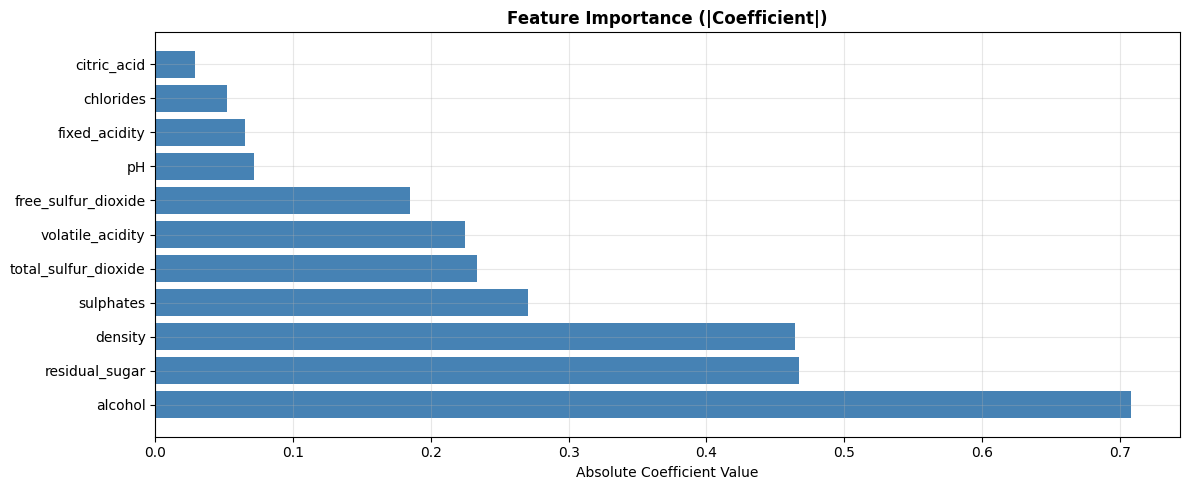

Top 5 Most Influential Features:
1. alcohol              (coef: +0.7083)
2. residual_sugar       (coef: +0.4670)
3. density              (coef: -0.4646)
4. sulphates            (coef: +0.2703)
5. total_sulfur_dioxide (coef: -0.2338)


In [99]:
# Feature importance
feature_names = X_train.columns
coefficients = model_logistic.theta.flatten()
importance = np.abs(coefficients)
sorted_idx = np.argsort(importance)[::-1]

plt.figure(figsize=(12, 5))
plt.barh(range(len(feature_names)), importance[sorted_idx], color='steelblue')
plt.yticks(range(len(feature_names)), [feature_names[i] for i in sorted_idx])
plt.title('Feature Importance (|Coefficient|)', fontweight='bold')
plt.xlabel('Absolute Coefficient Value')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Print top influential features
print("Top 5 Most Influential Features:")
print("=" * 40)
for i, idx in enumerate(sorted_idx[:5]):
    feature = feature_names[idx]
    coef = coefficients[idx]
    print(f"{i+1}. {feature:<20} (coef: {coef:+.4f})")

### Neural Network

Now let's build a neural network. I will start simple with one hidden layer that has the same number of neurons as the number of features (11).

In [100]:
class NeuralNetwork:
    """
    Simple 2-layer Neural Network wrapper for the existing implementation
    """
    
    def __init__(self, learning_rate=0.1, max_epochs=5000, tolerance=0.00001):
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.tolerance = tolerance
        self.theta_1 = None
        self.theta_2 = None
        self.loss_history = []
        self.is_trained = False
        
    def _sigmoid(self, z):
        """Sigmoid activation function"""
        return 1 / (1 + np.exp(-z))
    
    def _bce_loss(self, y, y_hat, eps=1e-8):
        """Binary cross-entropy loss"""
        y_hat = np.clip(y_hat, eps, 1 - eps)
        return -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
    
    def fit(self, X, y):
        """
        Train the neural network
        
        Parameters:
        X : array-like, shape (m, n) - training features
        y : array-like, shape (m, 1) - training targets (binary)
        """
        # Prepare data
        x = X.copy()
        m, n = x.shape
        x = np.hstack([np.ones((m, 1)), x])  # Add bias
        
        # Initialize weights
        #self.theta_1 = np.random.normal(0, 0.01, size=(n+1, n))
        #self.theta_2 = np.random.normal(0, 0.01, size=(n+1, 1))
        self.theta_1 = np.random.randn(n+1, n) * np.sqrt(2 / (n+1))
        self.theta_2 = np.random.randn(n+1, 1) * np.sqrt(2 / (n+1))
        
        self.loss_history = []
        
        print(f"Starting Neural Network training...")
        print(f"Samples: {m}, Learning rate: {self.learning_rate}")
        print()
        
        # Training loop
        for i in range(self.max_epochs):
            # Forward pass
            z_2 = x @ self.theta_1
            a_2 = self._sigmoid(z_2)
            a_2 = np.hstack([np.ones((m, 1)), a_2])  # Add bias
            
            z_3 = a_2 @ self.theta_2
            a_3 = self._sigmoid(z_3)
            
            # Calculate loss
            loss = self._bce_loss(y, a_3)
            self.loss_history.append(loss)
            
            # Print progress
            if i % 1000 == 0:
                print(f"Epoch {i:4d}: Loss = {loss:.6f}")
            
            # Check for convergence
            if len(self.loss_history) > 1:
                loss_change = abs(self.loss_history[-2] - self.loss_history[-1])
                if loss_change < self.tolerance:
                    print(f"Converged at epoch {i} (loss change: {loss_change:.2e})")
                    break
            
            # Backward pass - BCE loss with sigmoid
            delta_3 = a_3 - y
            grad_theta_2 = (a_2.T @ delta_3) / m
            
            delta_2_full = delta_3 @ self.theta_2.T
            delta_2 = delta_2_full[:, 1:]
            sigmoid_grad = a_2[:, 1:] * (1 - a_2[:, 1:])
            delta_2 *= sigmoid_grad  # element-wise
            
            grad_theta_1 = (x.T @ delta_2) / m
            
            # Gradient descent
            self.theta_1 -= self.learning_rate * grad_theta_1
            self.theta_2 -= self.learning_rate * grad_theta_2
        
        self.is_trained = True
        final_loss = self.loss_history[-1]
        print(f"Training completed. Final loss: {final_loss:.6f}")
        print("=" * 50)
        return self
    
    def predict_proba(self, X):
        """
        Predict class probabilities
        
        Parameters:
        X : array-like, shape (m, n) - input features
        
        Returns:
        probabilities : array-like, shape (m, 1) - predicted probabilities
        """
        if not self.is_trained:
            raise ValueError("Model must be trained before making predictions")
        
        x = X.copy()
        m, n = x.shape
        x = np.hstack([np.ones((m, 1)), x])  # Add bias
        
        # Forward pass
        z_2 = x @ self.theta_1
        a_2 = self._sigmoid(z_2)
        a_2 = np.hstack([np.ones((m, 1)), a_2])  # Add bias
        
        z_3 = a_2 @ self.theta_2
        a_3 = self._sigmoid(z_3)
        
        return a_3
    
    def predict(self, X, threshold=0.5):
        """
        Make binary predictions
        
        Parameters:
        X : array-like, shape (m, n) - input features
        threshold : float - decision threshold (default: 0.5)
        
        Returns:
        predictions : array-like, shape (m, 1) - binary predictions
        """
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)


In [101]:
# Example usage of the new Neural Network class and evaluation function

print("Training Neural Network using the new class-based implementation...")
print("=" * 60)

# Create and train the neural network
model_nn = NeuralNetwork(learning_rate=0.1, max_epochs=5000, tolerance=1e-10)
model_nn.fit(X_train_logistic, y_train_binary)

# Evaluate the neural network model
print("\nEvaluating Neural Network Model...")
print("=" * 45)

results_nn = evaluate_model(
    model_nn, X_train_logistic, y_train_binary, X_test_logistic, y_test_binary, model_nn.loss_history
)

print("Neural Network Performance Summary:")
print("-" * 45)
print(f"{'Metric':<15} {'Training':<12} {'Test':<12}")
print("-" * 45)
print(f"{'Accuracy':<15} {results_nn['train_accuracy']:<12.4f} {results_nn['test_accuracy']:<12.4f}")
print(f"{'Precision':<15} {results_nn['train_precision']:<12.4f} {results_nn['test_precision']:<12.4f}")
print(f"{'Recall':<15} {results_nn['train_recall']:<12.4f} {results_nn['test_recall']:<12.4f}")
print(f"{'F1-Score':<15} {results_nn['train_f1']:<12.4f} {results_nn['test_f1']:<12.4f}")

print(f"\nTraining Information:")
print("-" * 45)
print(f"{'Final Loss:':<20} {results_nn['final_loss']:.6f}")
print(f"{'Epochs Trained:':<20} {results_nn['epochs_trained']}")
print(f"{'Avg Recent Loss:':<20} {results_nn['avg_recent_loss']:.6f}")

Training Neural Network using the new class-based implementation...
Starting Neural Network training...
Samples: 5197, Learning rate: 0.1

Epoch    0: Loss = 1.017851
Epoch 1000: Loss = 0.377970
Epoch 2000: Loss = 0.372775
Epoch 3000: Loss = 0.369969
Epoch 4000: Loss = 0.367355
Training completed. Final loss: 0.364943

Evaluating Neural Network Model...
Neural Network Performance Summary:
---------------------------------------------
Metric          Training     Test        
---------------------------------------------
Accuracy        0.8322       0.7792      
Precision       0.6282       0.4265      
Recall          0.3757       0.4696      
F1-Score        0.4702       0.4470      

Training Information:
---------------------------------------------
Final Loss:          0.364943
Epochs Trained:      5000
Avg Recent Loss:     0.365058


Something that I've noticed as I've played around with this model is how senstive the metrics are the the number of epochs. Let's see if we can visaulize this.

Starting Neural Network training...
Samples: 5197, Learning rate: 0.1

Epoch    0: Loss = 0.631743
Training completed. Final loss: 0.462077
Starting Neural Network training...
Samples: 5197, Learning rate: 0.1

Epoch    0: Loss = 1.347229
Training completed. Final loss: 0.443386
Starting Neural Network training...
Samples: 5197, Learning rate: 0.1

Epoch    0: Loss = 0.935161
Training completed. Final loss: 0.386011
Starting Neural Network training...
Samples: 5197, Learning rate: 0.1

Epoch    0: Loss = 0.588957
Training completed. Final loss: 0.375070
Starting Neural Network training...
Samples: 5197, Learning rate: 0.1

Epoch    0: Loss = 0.795056
Epoch 1000: Loss = 0.378301
Training completed. Final loss: 0.373500
Starting Neural Network training...
Samples: 5197, Learning rate: 0.1

Epoch    0: Loss = 0.517490
Epoch 1000: Loss = 0.382937
Epoch 2000: Loss = 0.374948
Epoch 3000: Loss = 0.371795
Epoch 4000: Loss = 0.369354
Training completed. Final loss: 0.366896
Starting Neural Netw

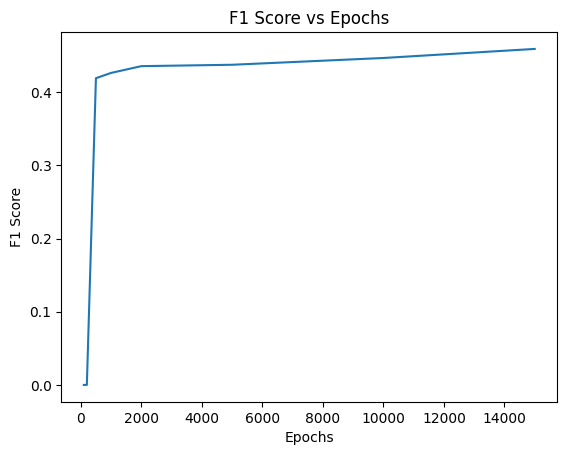

In [102]:
#Plot the f1 score as a function of the number of epochs

epoch_options = [100, 200, 500, 1000, 2000, 5000, 10000, 15000]
f1_scores = []

for epoch in epoch_options:
    model_nn = NeuralNetwork(tolerance = 0, max_epochs=epoch)
    model_nn.fit(X_train, y_train_binary)
    results_nn = evaluate_model(model_nn, X_train, y_train_binary, X_test, y_test_binary)
    f1_scores.append(results_nn['test_f1'])

plt.plot(epoch_options, f1_scores)
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Epochs')
plt.show()

It's still increasing, let's do more. And while we're at it, let's look at the training time as a function of the number of epochs.

Starting Neural Network training...
Samples: 5197, Learning rate: 0.2

Epoch    0: Loss = 0.566562
Training completed. Final loss: 0.430398
Starting Neural Network training...
Samples: 5197, Learning rate: 0.2

Epoch    0: Loss = 0.791509
Training completed. Final loss: 0.396086
Starting Neural Network training...
Samples: 5197, Learning rate: 0.2

Epoch    0: Loss = 0.992920
Training completed. Final loss: 0.375387
Starting Neural Network training...
Samples: 5197, Learning rate: 0.2

Epoch    0: Loss = 0.576997
Training completed. Final loss: 0.372282
Starting Neural Network training...
Samples: 5197, Learning rate: 0.2

Epoch    0: Loss = 0.634883
Epoch 1000: Loss = 0.373341
Training completed. Final loss: 0.367888
Starting Neural Network training...
Samples: 5197, Learning rate: 0.2

Epoch    0: Loss = 0.861873
Epoch 1000: Loss = 0.372571
Epoch 2000: Loss = 0.367020
Epoch 3000: Loss = 0.362384
Epoch 4000: Loss = 0.358073
Training completed. Final loss: 0.354208
Starting Neural Netw

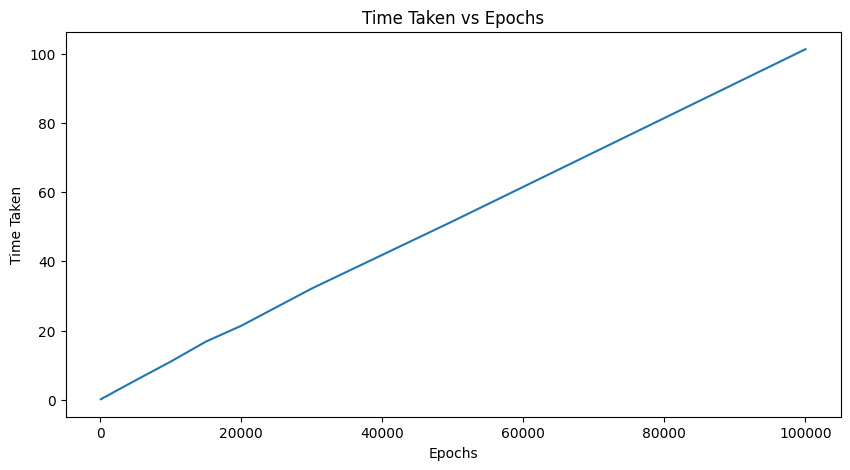

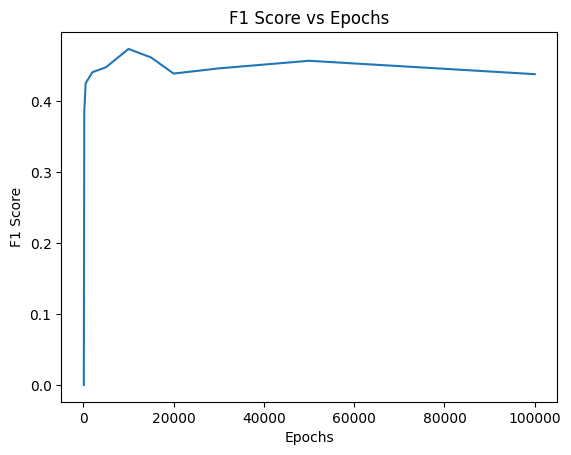

In [107]:
#Plot the f1 score as a function of the number of epochs

#Ok maybe this is a bit much. Let's increase the learning rate slightly instead.
#epoch_options = [100, 200, 500, 1000, 2000, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000, 80000, 85000, 90000, 95000, 100000]


epoch_options = [100, 200, 500, 1000, 2000, 5000, 10000, 15000, 20000, 30000, 50000, 100000]
time_taken = []

f1_scores = []

for epoch in epoch_options:
    
    model_nn = NeuralNetwork(tolerance = 0, learning_rate = 0.2, max_epochs=epoch)
    start_time = time()
    model_nn.fit(X_train, y_train_binary)
    end_time = time()
    time_taken.append(end_time - start_time)
    results_nn = evaluate_model(model_nn, X_train, y_train_binary, X_test, y_test_binary)
    f1_scores.append(results_nn['test_f1'])

# Plotting the time taken vs the number of epochs and the f1 score vs the number of epochs
plt.figure(figsize=(10, 5))
plt.plot(epoch_options, time_taken)
plt.xlabel('Epochs')
plt.ylabel('Time Taken')
plt.title('Time Taken vs Epochs')
plt.show()


plt.plot(epoch_options, f1_scores)
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Epochs')
plt.show()

The training time increases linearly with the number of epochs. This makes sense, because we are doing each training step (forward and backward pass) once for each epoch.

Regarding the F1 score, it's going down and I feel that I can stop :) 
I'm sure there's more systematic ways to better evaluate neural network performance. That's for a future post. Let's grab the model with the highest score and gather some final insights.

In [130]:
epoch_max_f1 = epoch_options[f1_scores.index(max(f1_scores))]
print(f"Number of epochs with max F1 score: {epoch_max_f1}")

#Grab the model with the highest F1 score
model_nn = NeuralNetwork(tolerance = 0, learning_rate = 0.2, max_epochs=epoch_max_f1)
model_nn.fit(X_train, y_train_binary)
results_nn = evaluate_model(model_nn, X_train, y_train_binary, X_test, y_test_binary, model_nn.loss_history)

Number of epochs with max F1 score: 10000
Starting Neural Network training...
Samples: 5197, Learning rate: 0.2

Epoch    0: Loss = 0.812907
Epoch 1000: Loss = 0.373132
Epoch 2000: Loss = 0.367693
Epoch 3000: Loss = 0.363011
Epoch 4000: Loss = 0.359227
Epoch 5000: Loss = 0.356221
Epoch 6000: Loss = 0.353545
Epoch 7000: Loss = 0.350889
Epoch 8000: Loss = 0.348202
Epoch 9000: Loss = 0.345558
Training completed. Final loss: 0.343044


In [132]:
# Evaluation
results_nn = evaluate_model(
    model_nn, X_train_logistic, y_train_binary, X_test_logistic, y_test_binary, model_nn.loss_history
)

print("Neural Network Performance Summary:")
print("-" * 45)
print(f"{'Metric':<15} {'Training':<12} {'Test':<12}")
print("-" * 45)
print(f"{'Accuracy':<15} {results_nn['train_accuracy']:<12.4f} {results_nn['test_accuracy']:<12.4f}")
print(f"{'Precision':<15} {results_nn['train_precision']:<12.4f} {results_nn['test_precision']:<12.4f}")
print(f"{'Recall':<15} {results_nn['train_recall']:<12.4f} {results_nn['test_recall']:<12.4f}")
print(f"{'F1-Score':<15} {results_nn['train_f1']:<12.4f} {results_nn['test_f1']:<12.4f}")

print(f"\nTraining Information:")
print("-" * 45)
print(f"{'Final Loss:':<20} {results_nn['final_loss']:.6f}")
print(f"{'Epochs Trained:':<20} {results_nn['epochs_trained']}")
print(f"{'Avg Recent Loss:':<20} {results_nn['avg_recent_loss']:.6f}")

Neural Network Performance Summary:
---------------------------------------------
Metric          Training     Test        
---------------------------------------------
Accuracy        0.8443       0.7885      
Precision       0.6662       0.4510      
Recall          0.4301       0.5223      
F1-Score        0.5227       0.4841      

Training Information:
---------------------------------------------
Final Loss:          0.343044
Epochs Trained:      10000
Avg Recent Loss:     0.343165


Number of poor quality wines: 1053 - 81.0%
Number of good quality wines: 247 - 19.0%


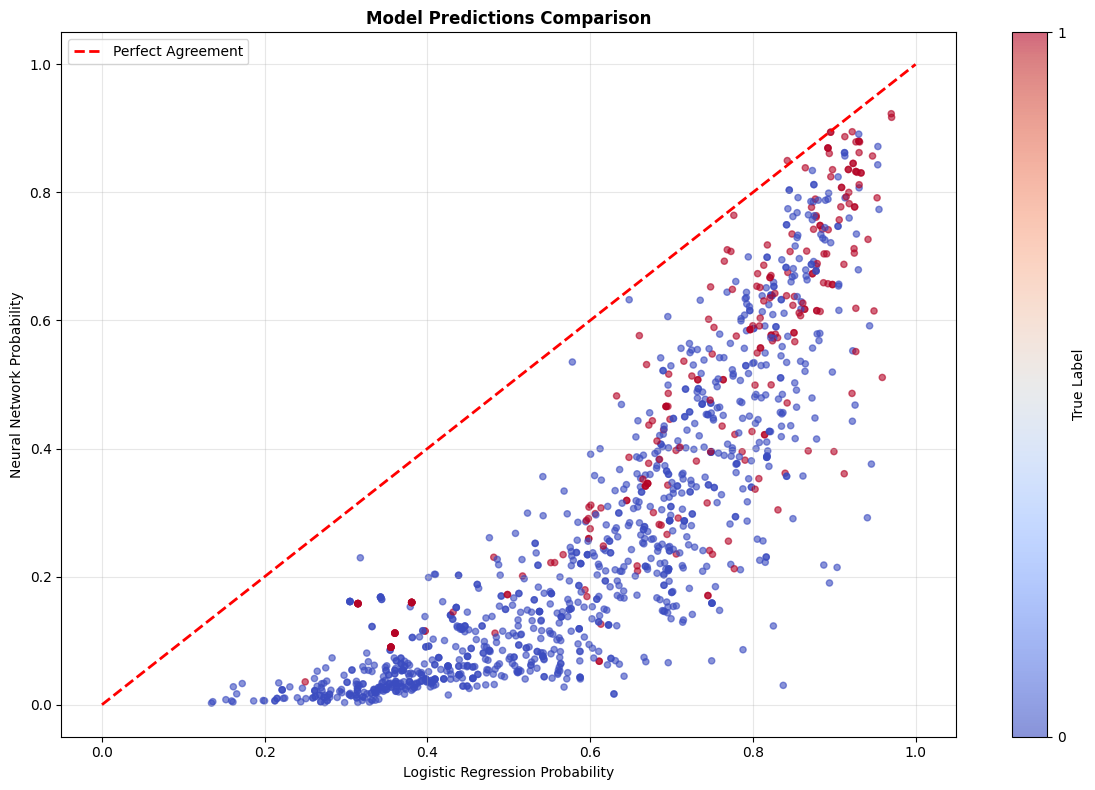

In [146]:
import matplotlib.pyplot as plt

# Get model predictions and true labels
nn_test_proba = results_nn['y_test_proba'].flatten()
lr_test_proba = results_logistic['y_test_proba'].flatten()

quality_counts = np.bincount(y_test_binary.flatten())
num_zeros = quality_counts[0]
num_ones = quality_counts[1]

print(f"Number of poor quality wines: {num_zeros} - {num_zeros/len(y_test_binary)*100}%")
print(f"Number of good quality wines: {num_ones} - {num_ones/len(y_test_binary)*100}%")

# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    lr_test_proba, nn_test_proba,
    c=y_test_binary,           # color by true label
    cmap='coolwarm',    # 0 = blue, 1 = red (or any other colormap)
    alpha=0.6, s=20
)

plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Agreement')
plt.title('Model Predictions Comparison', fontweight='bold')
plt.xlabel('Logistic Regression Probability')
plt.ylabel('Neural Network Probability')
plt.legend()
plt.grid(True, alpha=0.3)

# Optional: add color bar to show what colors mean
plt.colorbar(scatter, ticks=[0, 1], label='True Label')

plt.tight_layout()
plt.show()

The nueral network has a 78% accuracy on the test set - that's not bad at all. I'm impressed with its performance. I'd be interested to modify the architecture a bit see if that can improve.


When comparing it to the logistic regression model, the nueral network was more conservative. The models tended to agree more on the good quality wines as indicated by the clustering of points in the top right corner. 